## Model description

The free fall of a point particle of mass $m$ is governed by Newton's second law of motion, which re-written as a set of first order ODEs read:

$$
\left\{ \begin{array} \\x'(t)= & v(t)\\ v'(t) = & -g/m \end{array} \right.
$$
where $x$ is the ball’s height from the ground, $v$ is the ball’s vertical velocity, $m$ is the ball's mass and $g$ is the earth’s gravitational constant, and the independent variable $t$ represents *time*.

The "classical" bouncing ball is perhaps the simplest example of a hybrid ODE, since it presents only one discrete transition. The model consists of a ball dropped from a predefined height. It hits the ground after a certain time, loses energy and then bounces back into the air and starts to fall again.

The ball is assumed to bounce in the floor, hence the physical phenomena can be represented as the following hybrid automaton:

<img src="bball_automaton.png" alt="Drawing" style="width: 300px;"/>

We have considered that $m = g = 1$ (in their respective units). The invariant $x \geq 0$ enforces that the ball always bounces when it reaches the ground. The guard $x=0 \wedge v\leq0$ of the single discrete transition, which models the bouncing, ensures that bouncing happens after falling when reaching the ground. The corresponding reset condition $v:=-c \cdot v$ accounts for the loss of energy due to the ball’s deformation, where $c\in\left[0,1\right]$ is a constant known as [coefficient of restitution](https://en.wikipedia.org/wiki/Coefficient_of_restitution).

In [1]:
using Reachability, MathematicalSystems, HybridSystems

┌ Info: Recompiling stale cache file /home/mforets/.julia/compiled/v1.2/Reachability/CHV4V.ji for Reachability [774a0091-654f-5c65-bbdc-ad5b67b45832]
└ @ Base loading.jl:1240


The bouncing ball model has one mode, two continuous variables and one discrete jump. We begin by creating an empty instance of a hybrid automaton with one mode.

In [2]:
bball = LightAutomaton(1)

LightAutomaton{LightGraphs.SimpleGraphs.SimpleDiGraph{Int64},LightGraphs.SimpleGraphs.SimpleEdge{Int64}}({1, 0} directed simple Int64 graph, Dict{LightGraphs.SimpleGraphs.SimpleEdge{Int64},Dict{Int64,Int64}}(), 0, 0)

Next we define the **falling mode** as an affine ODE with a state constraint that corresponds to the invariant:

In [3]:
# model's constants
g = 9.81
m = 1.0
c = 0.75

# define "falling mode"
A = [0.0 1.0; 0.0 0.0]
b = [0.0, -g/m]
X = HalfSpace([-1.0, 0.0], 0.0) # invariant x >= 0
falling = ConstrainedAffineContinuousSystem(A, b, X);

modesvec = [falling]

1-element Array{ConstrainedAffineContinuousSystem{Float64,Array{Float64,2},Array{Float64,1},HalfSpace{Float64,Array{Float64,1}}},1}:
 ConstrainedAffineContinuousSystem{Float64,Array{Float64,2},Array{Float64,1},HalfSpace{Float64,Array{Float64,1}}}([0.0 1.0; 0.0 0.0], [0.0, -9.81], HalfSpace{Float64,Array{Float64,1}}([-1.0, 0.0], 0.0))

The "falling" mode has a self-loop, so we add a transition from the falling mode to itself.

In [4]:
add_transition!(bball, 1, 1, 1)

HybridSystems.LightTransition{LightGraphs.SimpleGraphs.SimpleEdge{Int64}}(Edge 1 => 1, 1)

The **reset map** is given by:

- A constrained linear map, $(x, v) \mapsto (x, -cv)$.
- A guard or constraint set given by the polyhedron $x = 0$ and $v \le 0$.

In [5]:
A = [1.0 0.0; 0.0 -c]

guard = HPolyhedron([HalfSpace([0.0, 1.0], 0.0),   # v ≤ 0
                     HalfSpace([-1.0, 0.0], 0.0),  # x ≥ 0
                     HalfSpace([1.0, 0.0], 0.0)])  # x ≤ 0

# alternative implementation:
# guard_v2 = Hyperplane([1.0, 0.0], 0.0) ∩ HalfSpace([0.0, 1.0], 0.0)

resetmaps = [ConstrainedLinearMap(A, guard)];

Switchings are autonomous:

In [6]:
switchings = [AutonomousSwitching()];

Finally we instantiate the hybrid system:

In [7]:
H = HybridSystem(bball, modesvec, resetmaps, switchings)

Hybrid System with automaton LightAutomaton{LightGraphs.SimpleGraphs.SimpleDiGraph{Int64},LightGraphs.SimpleGraphs.SimpleEdge{Int64}}({1, 1} directed simple Int64 graph, Dict(Edge 1 => 1 => Dict(1 => 1)), 1, 1)

## Reachability settings

We consider the inital set given by an uncertain initial position and certain momentum (at rest):

$$
 x \in [10, 10.2], v = 0.
$$

We use a time horizon of $T=40s$ and set the constant $c = 0.75$.

These settings are taken from the HyPro benchmarks [1].

[1] https://ths.rwth-aachen.de/research/projects/hypro/bouncing-ball/

In [8]:
X0 = Interval(10.0, 10.2) × Singleton([0.0])

# initial condition in "falling" mode
BouncingBall = InitialValueProblem(H, [(1, X0)]);

## Results

In [9]:
using Plots, LaTeXStrings

In [10]:
opC = GLGM06(Options(:δ=>0.05))
opD = LazyDiscretePost(:check_invariant_intersection => true)
sol = solve(BouncingBall, Options(:T=>10.0), opC, opD);

[warn | Reachability]: Several option aliases were used for aliases Symbol[:check_invariant_intersection].


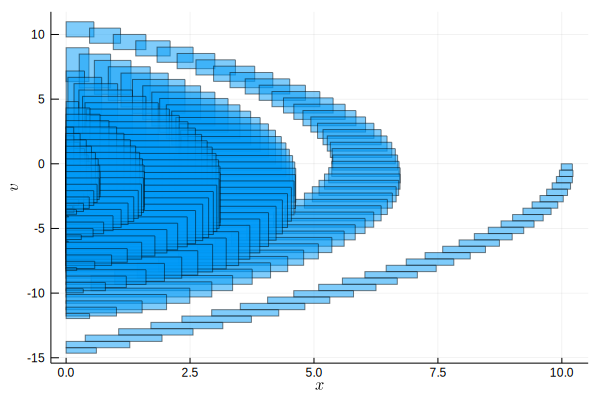

In [11]:
plot(sol, xlab=L"x", ylab=L"v", alpha=.5)

In [12]:
opC = BFFPSV18(Options(:δ=>0.1))
opD = LazyDiscretePost()
sol = solve(BouncingBall, Options(:T=>10.0, :project_reachset=>false, :plot_vars=>[1, 2], :max_jumps=>1), opC, opD);

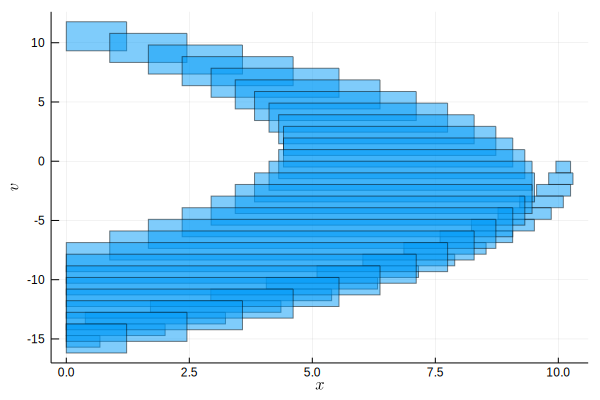

In [13]:
plot(sol, xlab=L"x", ylab=L"v", alpha=.5)

## Property checking

Let the set of *bad states* be the set of all states where $v \geq 10.7$.

In [14]:
BadStates = HalfSpace([0.0, -1.0], -10.7); # v >= 10.7

# Manual implementation

## Details about the continuous post-operator

In this section we explain with some details how does the continuous post-operator actually work.

**Discretization.** Given the initial set $X_0$, this set is bloated to get the first set of the sequence that we call $\mathcal{X}(0)$.

**Set-based recurrence.** The flowpipe is computed using GLGM06 (zonotope based algorithm).

**Intersection with the guard.** We check the first state whose intersection with the guard is non-empty, then compute the  

In [15]:
using Plots

In [16]:
include("GLGM06.jl")

reach_inhomog! (generic function with 2 methods)

The falling mode was defined earlier in this notebook.

In [17]:
X0 = Interval(10.0, 10.2) × Interval(0.0, 0.1)

CartesianProduct{Float64,Interval{Float64,IntervalArithmetic.Interval{Float64}},Interval{Float64,IntervalArithmetic.Interval{Float64}}}(Interval{Float64,IntervalArithmetic.Interval{Float64}}([10, 10.2]), Interval{Float64,IntervalArithmetic.Interval{Float64}}([0, 0.100001]))

In [18]:
X0h = convert(Hyperrectangle, X0)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([10.1, 0.05], [0.09999999999999964, 0.05])

In [19]:
falling

ConstrainedAffineContinuousSystem{Float64,Array{Float64,2},Array{Float64,1},HalfSpace{Float64,Array{Float64,1}}}([0.0 1.0; 0.0 0.0], [0.0, -9.81], HalfSpace{Float64,Array{Float64,1}}([-1.0, 0.0], 0.0))

In [20]:
P = InitialValueProblem(falling, X0h)

InitialValueProblem{ConstrainedAffineContinuousSystem{Float64,Array{Float64,2},Array{Float64,1},HalfSpace{Float64,Array{Float64,1}}},Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}}(ConstrainedAffineContinuousSystem{Float64,Array{Float64,2},Array{Float64,1},HalfSpace{Float64,Array{Float64,1}}}([0.0 1.0; 0.0 0.0], [0.0, -9.81], HalfSpace{Float64,Array{Float64,1}}([-1.0, 0.0], 0.0)), Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([10.1, 0.05], [0.09999999999999964, 0.05]))

In [21]:
sol1 = _solve_GLGM06(P, 0.1, 0.01);

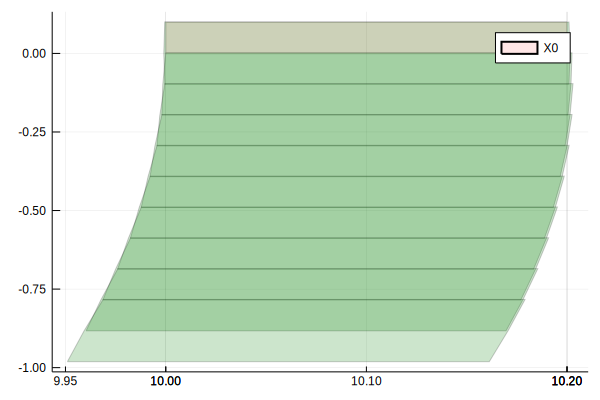

In [22]:
plot(X0, lab="X0", color=:red, lw=2., alpha=.1)
plot!([set(x) for x in sol1], lab="", alpha=.2, color="green")

In [23]:
flow = simulate(bball!, X0h, 0.1);

UndefVarError: UndefVarError: simulate not defined

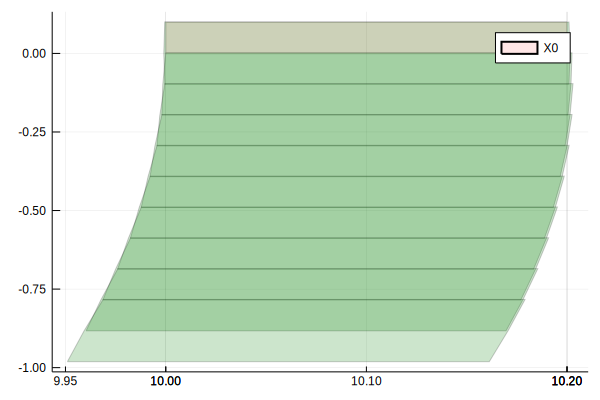

In [24]:
plt = plot(X0, lab="X0", color=:red, lw=2., alpha=.1)
plot!(plt, [set(x) for x in sol1], lab="", alpha=.2, color="green")

In [25]:
plot!(plt, flow[1], vars = (1, 2), color=:black, lw=.2, lab="")
for i in 2:length(flow)
    plot!(plt, flow[i], vars=(1, 2), color=:black, lw=.1, lab="")
end
plt

UndefVarError: UndefVarError: flow not defined

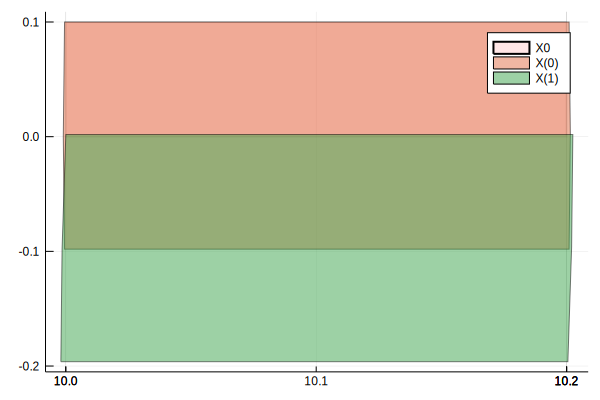

In [26]:
plot(X0, lab="X0", color=:red, lw=2., alpha=.1)
plot!([set(x) for x in sol1[1:1]], lab="X(0)", alpha=.5)
plot!([set(x) for x in sol1[2:2]], lab="X(1)", alpha=.5)

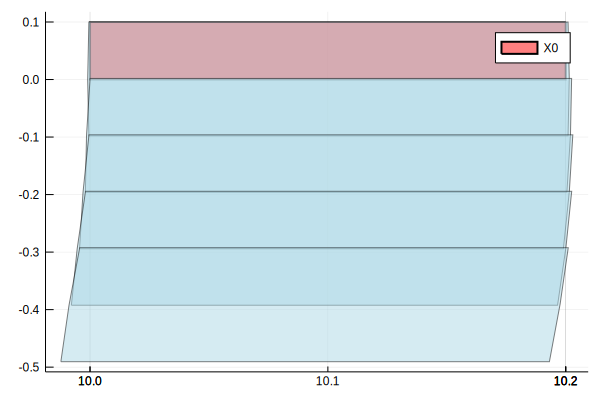

In [27]:
plot(X0, lab="X0", color=:red, lw=2.)
plot!([set(x) for x in sol1[1:5]], color=:lightblue)

### Parentesis; dibujando las trayectorias

In [28]:
using DifferentialEquations

function bball!(dx, x, p, t) 
    dx[1] = x[2]
    dx[2] = -9.81
end

u0 = LazySets.center(X0h)
tspan = (0.0, 3 * 0.01)
prob = ODEProblem(bball!, u0, tspan)

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 0.03)
u0: [10.1, 0.05]

In [29]:
trajectory = DifferentialEquations.solve(prob);

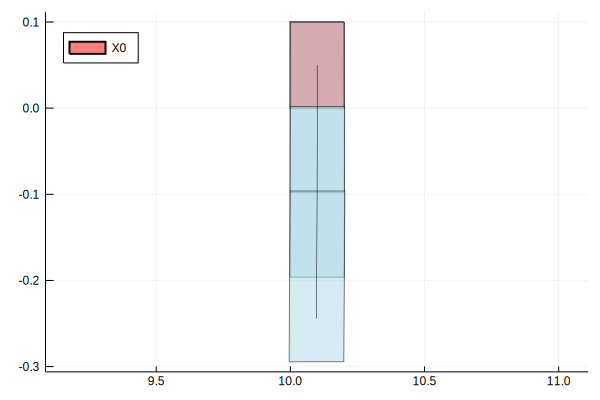

In [30]:
plot(X0, lab="X0", color=:red, lw=2.)
plot!([set(x) for x in sol1[1:3]], color=:lightblue)
plot!(trajectory, vars = (1, 2), color=:black, lw=.5, legend=:topleft, lab="")

In [31]:
using Distributions

In [32]:
function simulate(f, X, T; NSAMPLES=100)
    U = LazySets.sample(X0, NSAMPLES)
    tspan = (0.0, T)
    flow = []
    for u0 in U
        prob = ODEProblem(f, u0, tspan)
        trajectory = DifferentialEquations.solve(prob)
        push!(flow, trajectory)
    end
    return flow
end

simulate (generic function with 1 method)

In [33]:
flow = simulate(bball!, X0h, 1.0);

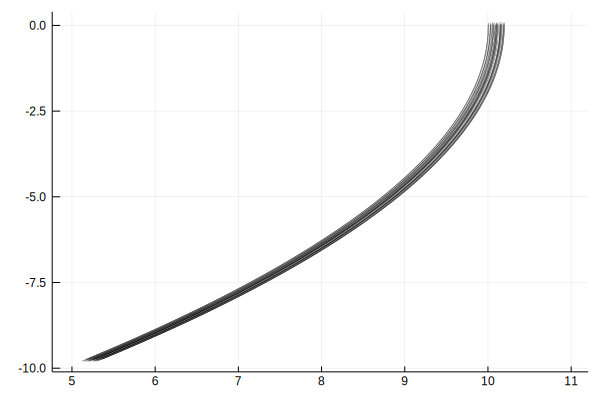

In [34]:
plt = plot(flow[1], vars = (1, 2), color=:black, lw=.2, lab="")
for i in 2:length(flow)
    plot!(plt, flow[i], vars=(1, 2), color=:black, lw=.1, lab="")
end
plt

## Flowpipe and trajectories

(This part can be executed independently of the rest of the notebook.)

In [35]:
sol = _solve_GLGM06(P, 1.0, 0.01);

In [36]:
flow = simulate(bball!, X0h, 1.0);

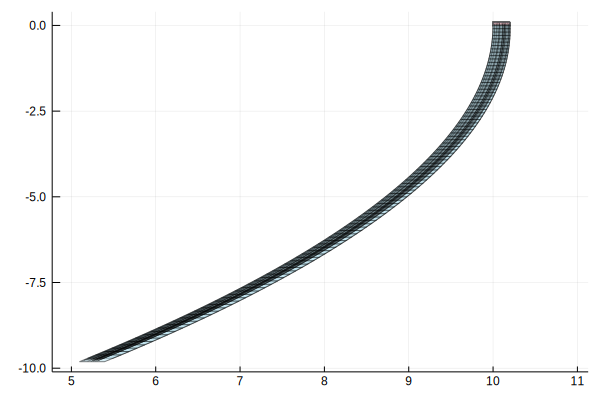

In [37]:
plt = plot(X0, lab="", color=:red, lw=2.)
plot!(plt, [set(x) for x in sol], color=:lightblue)
plot!(plt, flow[1], vars = (1, 2), color=:black, lw=.2, lab="")
for i in 2:length(flow)
    plot!(plt, flow[i], vars=(1, 2), color=:black, lw=.1, lab="")
end
plt

## Details about the discrete post-operator

Now we will compute the intersection between the flowpipe and the guard.

In [38]:
# this is the invariant
invariant = stateset(P.s)

# this is the guard
guard = HPolyhedron([HalfSpace([0.0, 1.0], 0.0),   # v ≤ 0
                     HalfSpace([-1.0, 0.0], 0.0),  # x ≥ 0
                     HalfSpace([1.0, 0.0], 0.0)])  # x ≤ 0

HPolyhedron{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,Array{Float64,1}}([0.0, 1.0], 0.0), HalfSpace{Float64,Array{Float64,1}}([-1.0, 0.0], 0.0), HalfSpace{Float64,Array{Float64,1}}([1.0, 0.0], 0.0)])

In [39]:
sol = _solve_GLGM06(P, 10.0, 0.01);
flow = simulate(bball!, X0h, 10.0);

In [40]:
for i in eachindex(sol)
    if !is_intersection_empty(set(sol[i]), guard)
        println("intersection is non-empty for index $i")
    end
end

intersection is non-empty for index 143
intersection is non-empty for index 144
intersection is non-empty for index 145
intersection is non-empty for index 146
intersection is non-empty for index 147


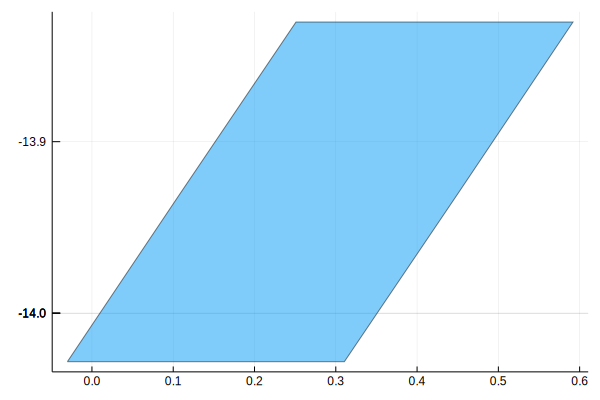

In [41]:
plot(set(sol[143]))

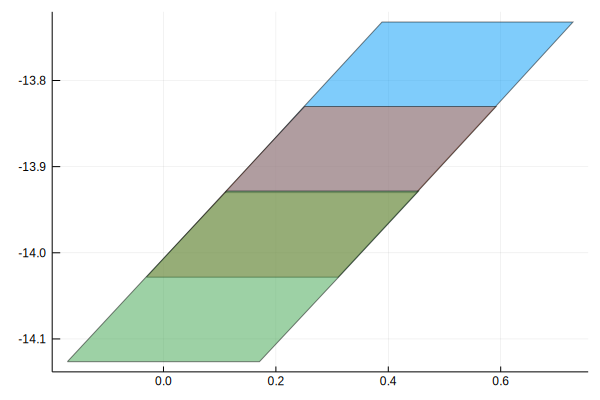

In [42]:
plot(set(sol[142]))
plot!(set(sol[143]))
plot!(set(sol[144]))
#plot!(flow[1], vars=(1, 2))

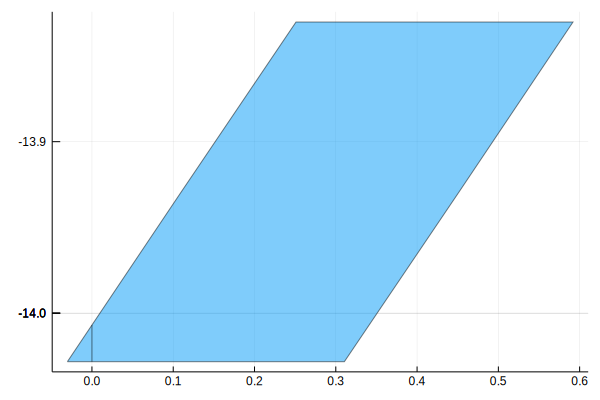

In [43]:
plot(set(sol[143]))
plot!(intersection(set(sol[143]), guard), color=:red)

In [44]:
sol[143].t_start, sol[143].t_end

(1.420000000000001, 1.430000000000001)

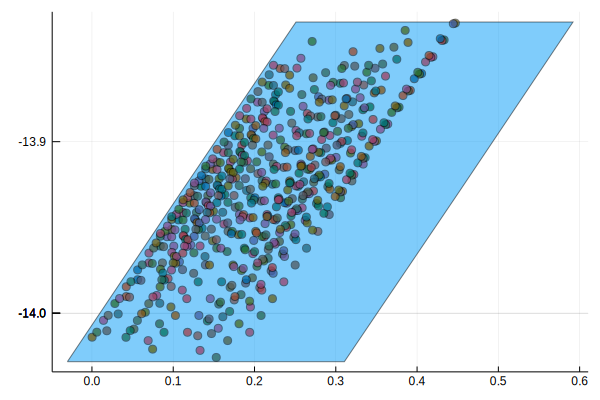

In [45]:
plt = plot(set(sol[143]))
for i in 1:50
    plot!(plt, [Singleton(x) for x in flow[i](1.42:0.001:1.43).u])
end
plt

In [46]:
M = [1.0 0.0; 0.0 -c]
resetmap = ConstrainedLinearMap(M, guard)

ConstrainedLinearMap{Float64,Array{Float64,2},HPolyhedron{Float64}}([1.0 0.0; 0.0 -0.75], HPolyhedron{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,Array{Float64,1}}([0.0, 1.0], 0.0), HalfSpace{Float64,Array{Float64,1}}([-1.0, 0.0], 0.0), HalfSpace{Float64,Array{Float64,1}}([1.0, 0.0], 0.0)]))

In [47]:
Y = intersection(set(sol[143]), guard)

HPolytope{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,Array{Float64,1}}([-0.5771626302313742, 0.8166292293718135], -11.438469594852892), HalfSpace{Float64,Array{Float64,1}}([0.0, -1.0], 14.02830000000002), HalfSpace{Float64,Array{Float64,1}}([-1.0, 0.0], 0.0), HalfSpace{Float64,Array{Float64,1}}([1.0, 0.0], 0.0)])

In [48]:
Ypost = apply(resetmap, Y)

LazySets.LinearMap{Float64,HPolytope{Float64},Float64,Array{Float64,2}}([1.0 0.0; 0.0 -0.75], HPolytope{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,Array{Float64,1}}([-0.5771626302313742, 0.8166292293718135], -11.438469594852892), HalfSpace{Float64,Array{Float64,1}}([0.0, -1.0], 14.02830000000002), HalfSpace{Float64,Array{Float64,1}}([-1.0, 0.0], 0.0), HalfSpace{Float64,Array{Float64,1}}([1.0, 0.0], 0.0)]))

In [49]:
vertices_list(Y)

2-element Array{Array{Float64,1},1}:
 [-0.0, -14.02830000000002] 
 [-0.0, -14.006931399763706]

In [50]:
vertices_list(Ypost)

2-element Array{Array{Float64,1},1}:
 [0.0, 10.521225000000015]
 [0.0, 10.50519854982278] 

In [51]:
Ypost

LazySets.LinearMap{Float64,HPolytope{Float64},Float64,Array{Float64,2}}([1.0 0.0; 0.0 -0.75], HPolytope{Float64}(HalfSpace{Float64,VN} where VN<:AbstractArray{Float64,1}[HalfSpace{Float64,Array{Float64,1}}([-0.5771626302313742, 0.8166292293718135], -11.438469594852892), HalfSpace{Float64,Array{Float64,1}}([0.0, -1.0], 14.02830000000002), HalfSpace{Float64,Array{Float64,1}}([-1.0, 0.0], 0.0), HalfSpace{Float64,Array{Float64,1}}([1.0, 0.0], 0.0)]))

In [52]:
# the first set should be a zonotope
Y0 = overapproximate(Ypost, Hyperrectangle)

Hyperrectangle{Float64,Array{Float64,1},Array{Float64,1}}([0.0, 10.513211774911397], [0.0, 0.008013225088618015])

In [53]:
Ppost = InitialValueProblem(falling, Y0)
sol = _solve_GLGM06(Ppost, 10.0, 0.01);
flow = simulate(bball!, Y0, 10.0);

In [54]:
plt = plot(Y0, lab="", color=:red, lw=2.)
plot!(plt, [set(x) for x in sol], color=:lightblue)
plot!(plt, flow[1], vars = (1, 2), color=:black, lw=.2, lab="")
for i in 2:length(flow)
    plot!(plt, flow[i], vars=(1, 2), color=:black, lw=.1, lab="")
end
plt

## Hybrid loop

### Preliminary: see if intersecting with the guard on the loop works

In [77]:
P = InitialValueProblem(falling, X0)

sol_without_guard_check = _solve_GLGM06(P, 10.0, 0.01, check_guard_intersection=false)

sol_with_guard_check = _solve_GLGM06(P, 10.0, 0.01, check_guard_intersection=true, guard=guard);

In [78]:
length(sol_without_guard_check)

1000

In [79]:
length(sol_with_guard_check)

141

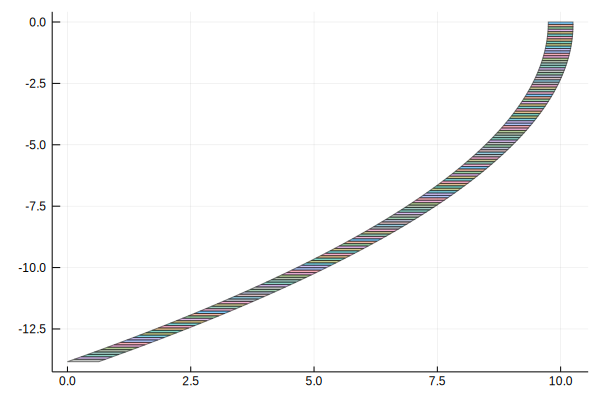

In [80]:
plot([set(x) for x in sol_with_guard_check])

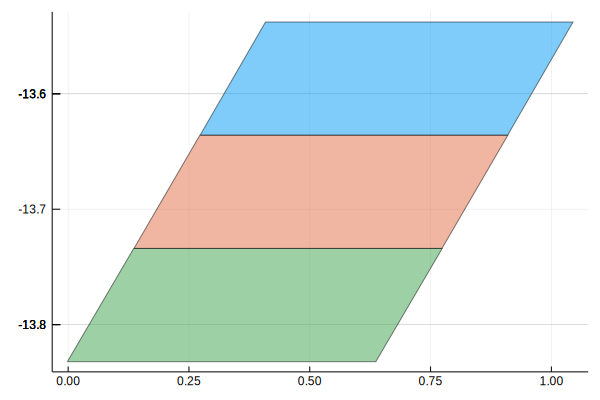

In [81]:
plot([set(x) for x in sol_with_guard_check[end-2:end]])

In [82]:
sol = _solve_GLGM06(P, 1.0, 0.1, check_guard_intersection=true, guard=guard);
typeof(sol)

Array{ReachSet{Zonotope{Float64}},1}

In [83]:
function solve_hybrid(problem, T, δ, max_jumps, guard, invariant)
    
    sol_tot = Vector{Vector{ReachSet{Zonotope{Float64}}}}()
    k = 1
    T_accum = 0.0

    while (k < max_jumps) && (T_accum < T)

        # compute flowpipe until hitting the guard for the first time
        sol = _solve_GLGM06(problem, T, δ, check_guard_intersection=true, guard=guard)
        
        # accumulate the time
        N = length(sol)
        T_accum = T_accum + N * δ

        # transform the intersection with the guard
        Rend = sol[end]
        Y = set(Rend)
        Z = intersection(Y, guard)
        R = apply(resetmap, Z) # lazy reset map
        
        # take intersection with the invariant
        H = convert(Zonotope, overapproximate(intersection(R, invariant), Hyperrectangle))
        
        problem = InitialValueProblem(problem.s, H) # prepare next system
        k += 1 # a jump was taken
        
        # take intersection with the invariant (it has to be a zonotope)
        Q = convert(Zonotope, overapproximate(intersection(Y, invariant), Hyperrectangle))
        sol[end] = ReachSet(Q, sol[end].t_start, sol[end].t_end)
        push!(sol_tot, sol) # save flowpipe
    end
    return sol_tot
end

solve_hybrid (generic function with 1 method)

In [87]:
max_jumps = 6 # maximum number of jumps
T = 20.0 # time horizon
δ = 0.01 # time step

P2 = IVP(P.s, Interval(10-0.25, 10+0.25) × Interval(0.0, 0.0))

F = solve_hybrid(P2, T, δ, max_jumps, guard, invariant);

  0.203409 seconds (856.13 k allocations: 100.321 MiB, 22.27% gc time)


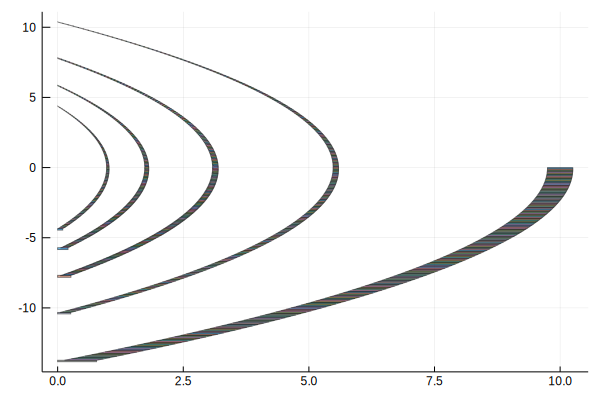

In [85]:
plot([set(x) for x in F[1]])
plot!([set(x) for x in F[2]])
plot!([set(x) for x in F[3]])
plot!([set(x) for x in F[4]])
plot!([set(x) for x in F[5]])

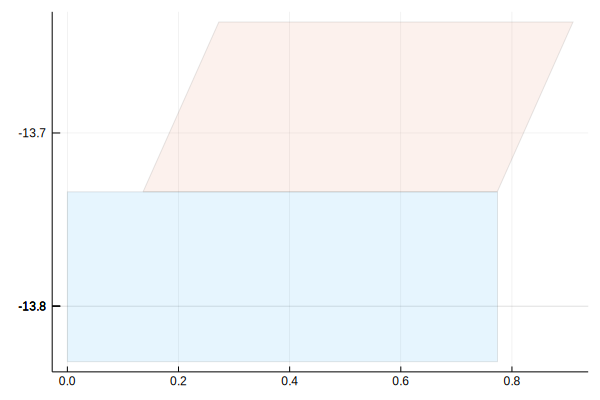

In [64]:
plot(set(last(F[1])), alpha=.1)
plot!(set(F[1][end-1]), alpha=.1)

## Plot close to the first jump

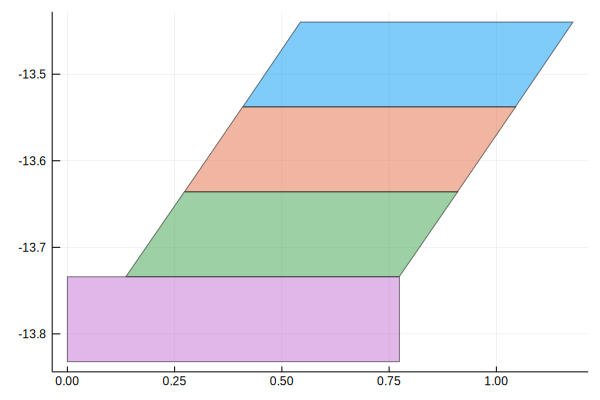

In [65]:
plot([set(x) for x in F[1][end-3:end]])

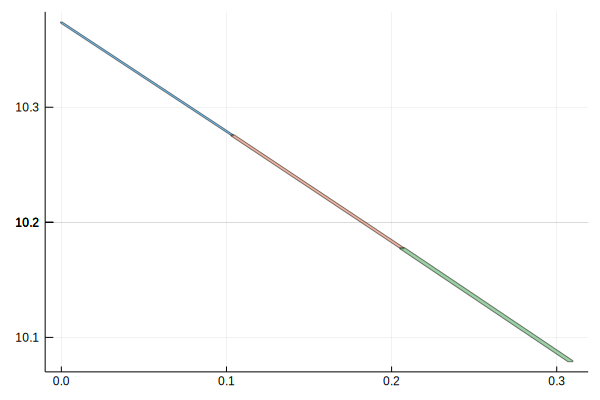

In [66]:
plot([set(x) for x in F[2][1:3]])

## Plot in the time domain

## Bouncing ball con Taylor models

In [67]:
using Reachability, TaylorIntegration, MathematicalSystems

function bouncing_ball!(dx, x, params, t)
    dx[1] = x[2]
    dx[2] = -9.81 * one(x[1])
    return dx
end

X0 = Interval(9.75, 10.25) × Interval(0.0, 0.0)
S = BlackBoxContinuousSystem(bouncing_ball!, 2)
P = InitialValueProblem(S, X0)

InitialValueProblem{BlackBoxContinuousSystem{typeof(bouncing_ball!)},CartesianProduct{Float64,Interval{Float64,IntervalArithmetic.Interval{Float64}},Interval{Float64,IntervalArithmetic.Interval{Float64}}}}(BlackBoxContinuousSystem{typeof(bouncing_ball!)}(bouncing_ball!, 2), CartesianProduct{Float64,Interval{Float64,IntervalArithmetic.Interval{Float64}},Interval{Float64,IntervalArithmetic.Interval{Float64}}}(Interval{Float64,IntervalArithmetic.Interval{Float64}}([9.75, 10.25]), Interval{Float64,IntervalArithmetic.Interval{Float64}}([0, 0])))

In [68]:
using LazySets: dim

O = Options(:T=>1.5, :mode=>"reach")
sol_zono = Reachability.solve(P, O, op=TMJets(:abs_tol=>1e-20, :orderT=>4, :orderQ=>2,
        :max_steps=>2_000, :output_type=>Zonotope));
#length(sol_zono.Xk)

In [69]:
O = Options(:T=>1.5, :mode=>"reach")
sol_zono = Reachability.solve(P, O, op=TMJets(:abs_tol=>1e-20, :orderT=>4, :orderQ=>2,
        :max_steps=>2_000, :output_type=>Zonotope));
#length(sol_zono.Xk)

In [70]:
O = Options(:T=>1.5, :mode=>"reach")
sol_box = Reachability.solve(P, O, op=TMJets(:abs_tol=>1e-20, :orderT=>4, :orderQ=>2,
        :max_steps=>2_000, :output_type=>Hyperrectangle));
length(sol_box.Xk)

4

In [71]:
import TaylorModels
using LazySets: center
import IntervalArithmetic
const IA = IntervalArithmetic

# opciones
f! = P.s.f
n = statedim(P)

# initial time and time horizon
t0 = 0.0
T = O[:T]

# maximum allowed number of steps
max_steps = 2_000

# unrap algorithm-specific options
abs_tol, orderQ, orderT = 1e-10, 2, 4

# initial sets
box_x0 = box_approximation(P.x0)
q0 = center(box_x0)
δq0 = IA.IntervalBox(low(box_x0)-q0, high(box_x0)-q0)

# fix the working variables and maximum order in the global
# parameters struct (_params_TaylorN_)
set_variables("x", numvars=length(q0), order=2*orderQ)

# define the property
property = (t, x) -> true

tTM, xTM, vTM = TaylorModels.validated_integ(f!, q0, δq0, t0, T, orderQ, orderT, abs_tol,
                maxsteps=max_steps, check_property=property);

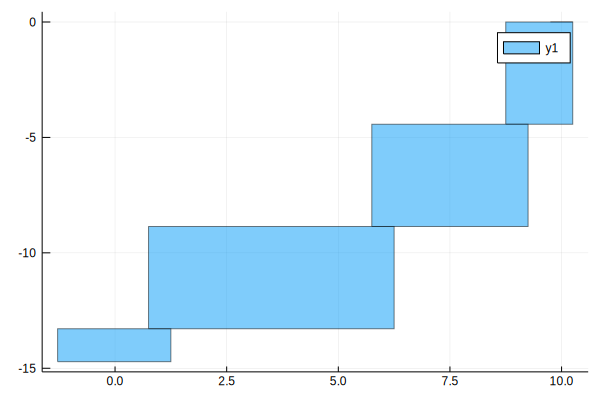

In [72]:
plot([x for x in xTM])

In [73]:
vTM[1, :]

5-element Array{TaylorModels.TaylorModel1{TaylorN{Float64},Float64},1}:
                                              10.0 + 0.25 x₁ + [0, 0]
                              10.0 + 0.25 x₁ + ( - 4.905) t² + [0, 0]
   9.0 + 0.25 x₁ + ( - 4.4294469180700204) t + ( - 4.905) t² + [0, 0]
    6.0 + 0.25 x₁ + ( - 8.858893836140041) t + ( - 4.905) t² + [0, 0]
   1.0 + 0.25 x₁ + ( - 13.288340754210061) t + ( - 4.905) t² + [0, 0]

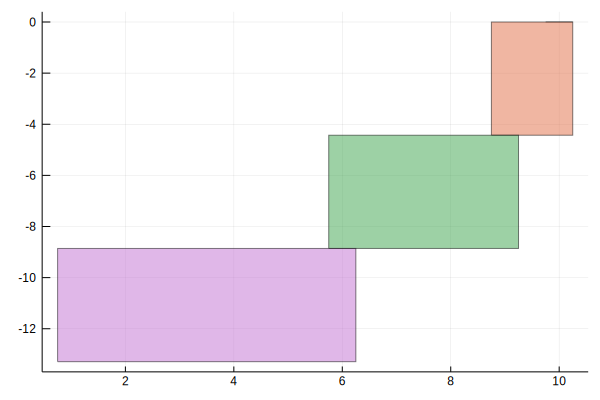

In [74]:
plot([set(x) for x in sol_zono.Xk])

In [75]:
plot([set(x) for x in sol_zono.Xk[120:127]])
plot!([set(x) for x in sol_box.Xk[120:127]])

BoundsError: BoundsError: attempt to access 4-element Array{ReachSet{Zonotope{Float64}},1} at index [120:127]